In [10]:
import os
import torch 
import numpy as np
import pandas as pd

## Check zenodo classifier

In [11]:
clf_prot = torch.load("/home/wp2181/LDB_data/microscopy/HPA/whole_images/zenodo/classifier_protein.pth", map_location=torch.device('cpu'))

In [12]:
clf_prot

OrderedDict([('first_layer.weight',
              tensor([[ 0.0435,  0.0267,  0.0190,  ..., -0.0257, -0.0386,  0.0078],
                      [-0.0114,  0.0211,  0.0083,  ...,  0.0093, -0.0300, -0.0087],
                      [ 0.0466,  0.0335,  0.0337,  ...,  0.0204, -0.0174,  0.0105],
                      ...,
                      [ 0.0061,  0.0095, -0.0381,  ..., -0.0134,  0.0101,  0.0318],
                      [-0.0161, -0.0043,  0.0285,  ...,  0.0147, -0.0114, -0.0387],
                      [-0.0546, -0.0094,  0.0481,  ..., -0.0204, -0.0384, -0.0052]])),
             ('first_layer.bias',
              tensor([ 0.0406, -0.0167,  0.0387,  ...,  0.0144,  0.0072,  0.0094])),
             ('final_layer.weight',
              tensor([[-0.0094,  0.0184, -0.0375,  ..., -0.0388, -0.0177,  0.0166],
                      [-0.0350,  0.0026,  0.0257,  ..., -0.0382, -0.0102,  0.0050],
                      [-0.0319, -0.0021,  0.0237,  ...,  0.0119, -0.0194, -0.0106],
                      .

### Run zenodo classifier with zenodo DINO_HPA_FOV_features.pth and compare against zenodo whole_images.csv:

In [110]:
import argparse
from utils.classification_utils import get_classifier
from utils.label_dict import protein_to_num_full

In [100]:
args = argparse.Namespace()

In [134]:
embed_dim = 768
args.competition_type = "whole_images"
args.num_classes = 28
args.classifier_type = "residual_add_clf"
args.n_layers = 2
args.n_units = 1024
args.skip = False
args.classifier_state_dict = "/home/wp2181/LDB_data/microscopy/HPA/whole_images/zenodo/classifier_protein.pth"
args.test_path = "/home/wp2181/LDB_data/microscopy/HPA/whole_images/zenodo/DINO_features_for_HPA_FOV.pth"

In [103]:
classifier = get_classifier(args, embed_dim)

In [271]:
msg = classifier.load_state_dict(
    torch.load(
        args.classifier_state_dict,
        map_location="cpu",
    )
)
print(msg)

<All keys matched successfully>


In [111]:
target_labels = sorted(list(protein_to_num_full.keys()))

In [112]:
for p in classifier.parameters():
    p.requires_grad = False
    classifier = classifier.eval()

In [113]:
mapping_dict = protein_to_num_full

In [147]:
# features, IDs, impaths = torch.load(args.test_path) ## Features are not structured as expected! 
dino_fts = torch.load(args.test_path, map_location=torch.device('cpu'))
features, IDs, impaths = dino_fts[0], dino_fts[3], dino_fts[4]["file"]

# What does actually happen here???! Is this necessary?
features = torch.Tensor(features)
target_labels = sorted(list(mapping_dict.keys()))
mapping = np.arange(args.num_classes)
for ind, p in enumerate(list(mapping_dict.keys())):
    mapping[ind] = target_labels.index(p)
predictions = []

# Generate predictions from features
for f in features:
    student_output = classifier(f.unsqueeze(0).to("cpu"))
    predictions.append(student_output.cpu().detach().numpy())
preds = np.concatenate(predictions, axis=0)

In [174]:
predictions = (
    torch.sigmoid(torch.Tensor(preds)).round().squeeze(1)[:, mapping]
)
submissions = []
for i in predictions:
    if len(i) == 0:
        submissions.append("")
    else:
        submissions.append(" ".join([str(v) for v in np.where(i)[0]]))

submission = pd.DataFrame(zip(IDs, submissions), columns=["Id", "Predicted"])
submission = submission.sort_values(by="Id")

In [281]:
submission

,Id,Predicted
86811,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,0
86812,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,0 1 7
86813,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,0 5
86814,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1 25
86815,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,0 18
...,...,...
117878,ffed4430-bbac-11e8-b2ba-ac1f6b6435d0,21
117879,fff0a998-bbae-11e8-b2ba-ac1f6b6435d0,0 5
117880,fff189d8-bbab-11e8-b2ba-ac1f6b6435d0,
117881,fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0,21 25


In [ ]:
# here I analyze the outputs etc. missing predictions and correspondence to zenodo dino_features vs. whole_images.csv

In [283]:
(predictions.sum(axis=1) == 0).sum(), (submission["Predicted"] == "").sum()

(tensor(18232), 18232)

In [286]:
# load zenodo reference csvs and compute scores:
path = "/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/"

zenodo = pd.read_csv(path + "zenodo/whole_images.csv")
train_ids = torch.load(path + "zenodo/train_IDs.pth")
valid_ids = torch.load(path + "zenodo/valid_IDs.pth")

zenodo_u = pd.read_csv(path + "zenodo/whole_images.csv").drop_duplicates(subset="ID")
train_ids = pd.DataFrame(train_ids, columns=["ID"]).drop_duplicates(subset="ID")
valid_ids = pd.DataFrame(valid_ids, columns=["ID"]).drop_duplicates(subset="ID")

In [287]:
# deduplicated train and valid IDs don't account for 27k images...
zenodo_u.shape[0] - train_ids.shape[0] - valid_ids.shape[0], zenodo_u.shape, train_ids.shape[0], valid_ids.shape[0]

(27711, (113545, 68), 72144, 18028)

In [254]:
# There are 10695 images that have no protein_loc label listed in the one-hot matrix. These all correspond to Website labels.
nolabels = zenodo[(zenodo.iloc[:,5:33].sum(axis=1) == 0)]
nolabels.shape, nolabels["protein_location"].unique()

((10695, 68),
 array(["['vesicles']", '[]', "['nucleoli rim', 'vesicles']",
        "['nucleoli rim']", "['nucleoli rim', 'mitotic chromosome']"],
       dtype=object))

In [269]:
nolabels_u = nolabels.drop_duplicates(subset="ID")
nolabels_u.shape

(9937, 68)

Need to remove the images with NO annotations from our classifier training and validation sets! 

In [265]:
train_predictions = submission[submission['Id'].isin(train_ids["ID"])].drop_duplicates(subset="Id")
valid_predictions = submission[submission['Id'].isin(valid_ids["ID"])].drop_duplicates(subset="Id")
assert train_predictions["Id"].isin(valid_predictions["Id"]).any() == False

In [261]:
(train_predictions["Predicted"] == "").sum(), (valid_predictions["Predicted"] == "").sum()

(10264, 2529)

In [208]:
# loading annotations from the DINO_features.pth
zenodo_pth_IDs = dino_fts[3]
zenodo_pth_preds = dino_fts[1]
zenodo_pth_targs = dino_fts[2]

In [212]:
zenodo_pth_preds.shape, zenodo_pth_targs.shape

(torch.Size([117883, 28]), (117883, 35))

In [218]:
zenodo.iloc[:,5:]

,nucleoplasm,nuclear membrane,nucleoli,nucleoli fibrillar center,nuclear speckles,nuclear bodies,endoplasmic reticulum,golgi apparatus,peroxisomes,endosomes,...,RT4,SH-SY5Y,SK-MEL-30,SiHa,SuSa,THP-1,U-2 OS,U-251 MG,hTCEpi,hTERT-RPE1
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117878,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117879,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
117880,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
117881,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Check zenodo feature csvs

In [115]:
fov_embs = pd.read_csv("/home/wp2181/LDB_data/microscopy/HPA/whole_images/zenodo/DINO_FOV_embeddings.csv")

In [117]:
fov_embs # just includes the UMAPs in extra columns

,Unnamed: 0,file,protein_location,cell_type,ID,nucleoplasm,nuclear membrane,nucleoli,nucleoli fibrillar center,nuclear speckles,...,lipid droplets,plasma membrane,cell junctions,mitochondria,aggresome,cytosol,cytoplasmic bodies,rods & rings,UMAP_1,UMAP_2
0,0,/scr/mdoron/Dino4Cells/data/whole_images/49232...,['vesicles'],A-431,49232_769_H3_1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-14.328590,-10.398324
1,1,/scr/mdoron/Dino4Cells/data/whole_images/49232...,['vesicles'],A-431,49232_769_H3_11,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-14.977192,-10.265456
2,2,/scr/mdoron/Dino4Cells/data/whole_images/49232...,['vesicles'],U-2 OS,49232_761_H3_1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,13.438740,15.927193
3,3,/scr/mdoron/Dino4Cells/data/whole_images/49232...,['vesicles'],U-2 OS,49232_761_H3_2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,13.878462,17.346966
4,4,/scr/mdoron/Dino4Cells/data/whole_images/49232...,['vesicles'],U-251 MG,49232_757_H3_1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,-16.806204,9.091037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117878,117878,/scr/mdoron/Dino4Cells/data/whole_images/ffed4...,['plasma membrane'],ASC TERT1,ffed4430-bbac-11e8-b2ba-ac1f6b6435d0,False,False,False,False,False,...,False,True,False,False,False,False,False,False,13.359716,-6.184863
117879,117879,/scr/mdoron/Dino4Cells/data/whole_images/fff0a...,['nuclear bodies'],BJ,fff0a998-bbae-11e8-b2ba-ac1f6b6435d0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,11.107221,-1.429197
117880,117880,/scr/mdoron/Dino4Cells/data/whole_images/fff18...,['golgi apparatus'],HeLa,fff189d8-bbab-11e8-b2ba-ac1f6b6435d0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,31.051903,-26.846312
117881,117881,/scr/mdoron/Dino4Cells/data/whole_images/fffdf...,"['cytosol', 'nucleoli', 'plasma membrane']",A-431,fffdf7e0-bbc4-11e8-b2bc-ac1f6b6435d0,False,False,True,False,False,...,False,True,False,False,False,True,False,False,30.350204,-26.031130


## Check label distribution in zenodo DINO_fts vs. Master:

In [13]:
dino_fts = torch.load("/home/wp2181/LDB_data/microscopy/HPA/whole_images/zenodo/DINO_features_for_HPA_FOV.pth", map_location=torch.device('cpu'))

In [18]:
for i in dino_fts: 
    try: print(i.shape)
    except: print(len(i))

torch.Size([117883, 768])
torch.Size([117883, 28])
(117883, 35)
117883
(117883, 68)


In [23]:
dino_fts[1].sum(axis=0)

tensor([ 1769,   494,  2040,  3237,  1245,   716, 34302,  3509,   141,  1196,
         8073,  1850,   356,   132,    43,  1647,  2544,  9509,   438,  5370,
         2756,  4897,  8651,  3310, 50821,   199, 12859,    65])

In [27]:
path = "/mnt/vast/hpc/LDB/LDB_data/microscopy/HPA/whole_images/"

master = pd.read_csv(path + "Master_fovHPA_512.csv")
zenodo = pd.read_csv(path + "zenodo/whole_images.csv")

In [28]:
# confirm difference in shape is explained by duplicates in zenodo csv
master.shape, zenodo.shape, zenodo.duplicated(subset="ID").sum()

((113545, 71), (117883, 68), 4338)

In [31]:
# is there bias with respect to the labels of the duplicated images? 
dups = zenodo[zenodo.duplicated(subset="ID")]

In [59]:
dups_unique = dups.drop_duplicates(subset="ID")

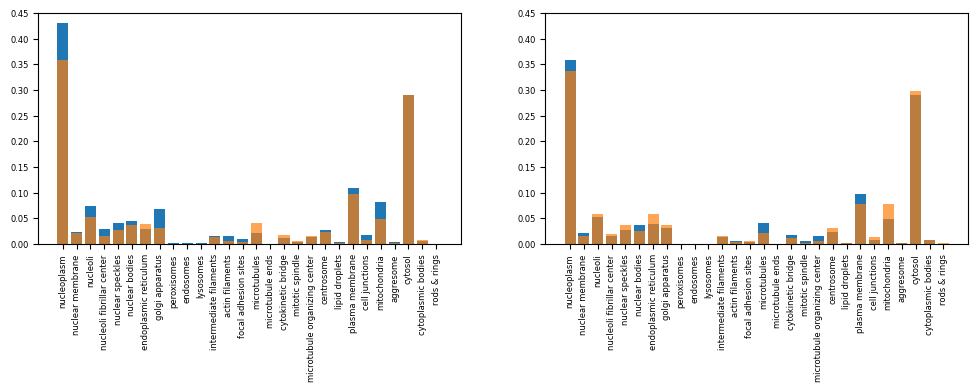

In [79]:
# check label distribution
import matplotlib.pyplot as plt

prot_col = dups.iloc[:,5:33].columns

# Protein locations:
fig, ax = plt.subplots(1,2, figsize=(12,3))
ax[0].bar(prot_col, zenodo.iloc[:,5:33].sum(axis=0) / zenodo.shape[0])
ax[0].bar(prot_col, dups.iloc[:,5:33].sum(axis=0) / dups.shape[0], alpha=0.7)
ax[1].bar(prot_col, dups.iloc[:,5:33].sum(axis=0) / dups.shape[0])
ax[1].bar(prot_col, dups_unique.iloc[:,5:33].sum(axis=0) / dups_unique.shape[0], alpha=0.7)

for i in range(1): ax[i].tick_params('x', )
for a in ax.flatten():
    a.set_ylim(0,0.45)
    a.tick_params(axis='x', which='major', labelsize=6, labelrotation=90)
    a.tick_params(axis='y', which='major', labelsize=6)

In [82]:
zenodo_rel = zenodo.iloc[:,5:33].sum(axis=0) / zenodo.shape[0]
dups_rel = dups.iloc[:,5:33].sum(axis=0) / dups.shape[0]

In [90]:
print("Duplicates in zenodo effectively oversample the following classes:")
for i in prot_col[(dups_rel > zenodo_rel).values]: print(f"-{i}")

Duplicates in zenodo effectively oversample the following classes:
-endoplasmic reticulum
-microtubules
-cytokinetic bridge
-mitotic spindle
-microtubule organizing center
-cytoplasmic bodies
